<a href="https://colab.research.google.com/github/invisilico/ActivityExtractor/blob/master/Activity_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Android Activity TimeStamps Extractor!

Inspired by the De La Iglesias Lab project on E-mail Timestamps, this notebook helps you easily extract, clean and visualise your Android phone's activity data based on timestamps on when apps were opened. 

A pandas dataframe is created with the following structure and is saved as CSV at the end of the notebook.


---


```
# dataframe structure

   App      Year    Month  Date  Time  of24h
0  Appname  2020    7      10    1534  15.566667
1  Appname  2020    7      10    1434  14.566667
2  Appname  2020    7      11    1534  15.566667
```


---

For this notebook, there are certain privacy measures you can take:

1. Make a copy of this notebook in your drive using the "Copy to Drive" button, and delete once the CSV is downloaded.

2. The files are removed explicitly at the data upload step, but some data may be left. To ensure they are removed, check the files tab on the left once prompted, and terminate session when leaving.

Instructions for using colab: the [ ] on the left of each "block"/"cell" runs them. Run them in order and wait for them to finish. If you run into errors, feel free to contact me at nishantjana5@gmail.com 


---


Made by Nishant Jana during SRBR ChronoSchool 2020.

Twitter: @in_visilico, Github: @invisilico


---



In [ ]:
#@title Simple Set-Up
#@markdown Click the ["play"] button on the left and wait for colab to allocate system resources. Once done, click play on each subsequent block.
import json
import csv
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from calendar import monthrange
from calendar import isleap

In [ ]:
#@title Load Data from File
#@markdown This block will keep running till you select the file. Click the "Choose Files" tile as it appears to select file to upload from your system. The file will be deleted once data is loaded.
file = files.upload()
name = list(file.keys())[0] 
data = json.loads(file[name]) #loads data from JSON
print("Data Loaded from JSON File.")

!rm *.* #removes file, bash shell command
print("JSON File deleted from Colab, verify in files on left panel.")

In [ ]:
#@title Build DataFrame
#@markdown This block will extract the data from JSON and create a pandas array. The CSV downloaded at the end can be read into python as a pandas dataframe and R as Rdata. Once done it should print the topmost and bottom-most entries and size of the dataframe.
#@markdown 
#@markdown Scroll to the end of the notebook to download CSV or continue to plot activity data.
#@markdown 
#@markdown Appnames are there for three reasons:
#@markdown 
#@markdown 1. Activity of apps like clock and calendar can inform you of the days on which you were woken up by alarms.
#@markdown 2. You can track activity of certain apps that are work related or others that are leisure related.
#@markdown 3. They help clean the data. Some system apps register sporadically even when the phone was not being used. Their activity changes phone to phone and needs manual sorting.
#@markdown 
#@markdown Note: Activity on the app is not read from the json data for privacy purposes.
appname = []
datetime = []

for dict in data:
    appname += [dict['header']]
    datetime += [dict['time']]
    
appname.reverse()
datetime.reverse()

yy = []
mm = []
dd = []
time = []
of24 = []

for t in datetime:
    yy += [int(t[0:4])]
    mm += [int(t[5:7])]
    dd += [int(t[8:10])]
    time += [int(t[11:13])*100 + int(t[14:16])]
    of24 += [int(t[11:13])+(int(t[14:16])/60)]

dataframe = pd.DataFrame(list(zip(appname,yy,mm,dd,time,of24)),columns = ['App','Year','Month','Date','Time','of24h'])
print(dataframe)

In [ ]:
#@title TimeZone Adjusted DataSet
timezone = 5.5 #@param {type:"number"}
hoffset = np.floor(timezone) * (timezone/abs(timezone))
minoffset = (timezone - np.floor(timezone))*60
#@markdown Set to timezone for your country of origin. Ex: India = (5.5), EDT = (-4)
#@markdown 
#@markdown If set to zero, timestamps will be in UTC.
appname = []
datetime = []

for dict in data:
    appname += [dict['header']]
    datetime += [dict['time']]
    
appname.reverse()
datetime.reverse()

yy = []
mm = []
dd = []
time = []
of24 = []

for t in datetime:
    y = int(t[0:4])
    m = int(t[5:7])
    d = int(t[8:10])
    h = int(t[11:13]) + hoffset
    min = int(t[14:16]) + minoffset
    if min > 59:
      min -= 60
      h += 1
    if h > 23:
      h -= 24
      d += 1
    if d > monthrange(y,m)[1]:
      d -= monthrange(y,m)[1]
      m += 1
    if m > 12:
      m -= 12
      y += 1
    yy += [y]
    mm += [m]
    dd += [d]
    time += [h*100 + min]
    of24 += [h + (min/60)]

dataframe = pd.DataFrame(list(zip(appname,yy,mm,dd,time,of24)),columns = ['App','Year','Month','Date','Time','of24h'])
print(dataframe)

In [ ]:
#@title Cleaning Dataset
#@markdown Run Once to see unique App names. Then type in one App name at a time to remove all instances of it from the dataframe.

App = "" #@param {type:"string"}

Unique = dataframe.App.unique()
print(Unique)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


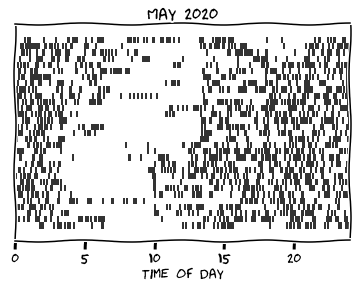

In [ ]:
#@title Raster Plot Activity

#@markdown Specify data, month or year or leave empty for all time.

Year  =   2020#@param {type:"integer"}
Month =  5#@param {type:"integer"}
Day   =  0#@param {type:"integer"}
#@markdown Inputs of Day and Month require Inputs of the higher category, therefore for Day, month and Year must be provided and for Month, Year must be provided.
#@markdown  
#@markdown Set 0 for null entry (all data )
with_XKCD = True #@param {type:"boolean"}
error = "No data for given timeframe."
monthnames  = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September" ,10:"October", 11:"November", 12:"December"}
month = monthnames.keys()
def prepdata(dataframe, y, m, d):
#prepares data for plot

  if y > 0 and m > 0 and d > 0:
    # For a specific date
    frame = dataframe.query(('Year == '+str(y)+' and Month == '+str(m)+' and Date == '+str(d)))
    if frame.size == 0:
      print(error)
      return error
    
    plotdata = frame.of24h.to_numpy()
    #Done

  elif y > 0 and m > 0:
    # For a Month
    frame = dataframe.query(('Year == '+str(y)+' and Month == '+str(m)))
    if frame.size == 0:
      print(error)
      return error
    
    days = monthrange(y,m)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Date == '+str(d+1)))
      plotdata[d] = daydata.of24h.to_numpy()
      #Done

  elif y > 0:
    # For a Year
    frame = dataframe.query(('Year == '+str(y)))
    if frame.size == 0:
      print(error)
      return error
    m = 1
    plotdata = np.empty(0, dtype = object)
    while m < 12:
      days = monthrange(y,m)[1]
      monthdata = np.empty(days, dtype = object)
      for d in range(days):
          daydata = frame.query(('Date == '+str(d+1)))
          monthdata[d] = daydata.of24h.to_numpy()
      plotdata = np.concatenate((plotdata,monthdata))
      m += 1
    #Done
  else:
    # All time
    Years = dataframe.Year.unique()
    plotdata = np.empty(0, dtype = object)
    for y in Years:
      frame = dataframe.query(('Year == '+str(y)))
      m = 1
      yeardata = np.empty(0, dtype = object)
      while m < 12:
        days = monthrange(y,m)[1]
        monthdata = np.empty(days, dtype = object)
        for d in range(days):
          daydata = frame.query(('Date == '+str(d+1)))
          monthdata[d] = daydata.of24h.to_numpy()
        yeardata = np.concatenate((yeardata,monthdata))
        m += 1
      plotdata = np.concatenate((plotdata,yeardata))
        #Done
  return plotdata

def Raster(plotdata, y, m, d, xkcd):
  if plotdata[0] != error:
    if xkcd == 1:
      if y > 0 and m > 0 and d > 0:
        with plt.xkcd():
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title((str(d)+" "+str(monthnames[m])+" "+str(y)))
          plt.xlim(0,24)
          plt.yticks([])
      elif y > 0 and m > 0:
        with plt.xkcd():
          plt.eventplot(plotdata[:], color = "0.2")
          plt.xlabel("Time of Day")
          plt.title((str(monthnames[m])+" "+str(y)))
          plt.xlim(0,24)
          plt.yticks([])
      elif y > 0:
        with plt.xkcd():
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title(("Year of "+str(y)))
          plt.xlim(0,24)
          plt.yticks([])
      else:
        with plt.xkcd():
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title("All Time")
          plt.xlim(0,24)
          plt.yticks([])
    else:
      if y > 0 and m > 0 and d > 0:
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title((str(d)+" "+str(monthnames[m])+" "+str(y)))
          plt.xlim(0,24)
          plt.yticks([])
      elif y > 0 and m > 0:
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title((str(monthnames[m])+" "+str(y)))
          plt.xlim(0,24)
          plt.yticks([])
      elif y > 0:
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title(("Year of "+str(y)))
          plt.xlim(0,24)
          plt.yticks([])
      else:
          plt.eventplot(plotdata, color = "0.2")
          plt.xlabel("Time of Day")
          plt.title("All time")
          plt.xlim(0,24)
          plt.yticks([])  

plotdata = prepdata(dataframe, Year, Month, Day)
#print(plotdata.shape)
Raster(plotdata,Year,Month,Day,with_XKCD)

In [ ]:
#@title Download Parsed Data as CSV
OutputFile = 'Data' #@param {type:"string"}
name = OutputFile+".csv"
dataframe.to_csv(name) 
files.download(name)